In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(123)

In [2]:
# 1. Generate synthetic data
means = [0, 1, 0]
stds = [0.3, 0.3, 0.3]
sizes = [10, 10, 10]

segments = [np.random.normal(loc=mean, scale=std, size=size)for mean, std, size in zip(means, stds, sizes)]
X = np.concatenate(segments)
X[26] = 1.2

In [3]:
# 2. MOSUM implementation
def mosum_stat(X, G):
    n = len(X)
    T = np.zeros(n)
    for k in range(G, n - G):
        left = X[k-G:k]
        right = X[k:k+G]
        T[k] = (np.mean(right) - np.mean(left)) * np.sqrt(G / 2)
    return T

def local_var(X, G, k):
    left = X[k-G:k]
    right = X[k:k+G]
    var = (np.var(left) + np.var(right)) / 2
    return np.sqrt(var)

def mosum_test(X, G, alpha=0.05):
    n = len(X)
    T = mosum_stat(X, G)
    MOSUM = np.zeros(n)
    for k in range(G, n-G):
        std = local_var(X, G, k)
        if std > 0:
            MOSUM[k] = abs(T[k]) / std
    
    # Gumbel threshold (approximate)
    x = n / G
    a = np.sqrt(2 * np.log(x))
    b = 2 * np.log(x) + 0.5 * np.log(np.log(x)) + np.log(3/2) - 0.5 * np.log(np.pi)
    c_alpha = -np.log(np.log(1 / np.sqrt(1 - alpha)))
    threshold = (b + c_alpha) / a
    return MOSUM, threshold

In [4]:
# 3. Detect changepoints
G = 5
MOSUM, threshold = mosum_test(X, G)
changepoints = []
above = MOSUM > threshold
in_region = False
for i in range(len(MOSUM)):
    if above[i] and not in_region:
        region_start = i
        in_region = True
    elif not above[i] and in_region:
        region_end = i
        peak = region_start + np.argmax(MOSUM[region_start:region_end])
        changepoints.append(peak)
        in_region = False

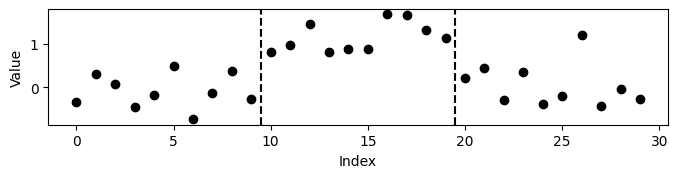

In [5]:
fig, ax = plt.subplots(figsize=(8, 1.5))
ax.scatter(np.arange(len(X)), X, marker='o', color='black')
for c in changepoints:
    ax.axvline(x = c - 0.5, color='black', linestyle='--')
ax.set_xlabel('Index')
ax.set_ylabel('Value')
plt.show()